In [ ]:
import numpy as np
from cvxopt import solvers, matrix
import matplotlib.pyplot as plt

In [ ]:
P = matrix(np.array([[2,0], [0,8]]), tc ='d')
q = matrix(np.array([-8, -16]), tc ='d')
G = matrix(np.array([[1,1], [1,0], [-1,0], [0,-1]]), tc = 'd')
h = matrix(np.array([5,3,0,0]), tc = 'd')
sol = solvers.qp(P, q, G, h)


     pcost       dcost       gap    pres   dres
 0: -3.0512e+01 -3.8829e+01  8e+00  0e+00  2e-01
 1: -3.0792e+01 -3.1146e+01  4e-01  2e-16  5e-03
 2: -3.0982e+01 -3.1024e+01  4e-02  2e-16  4e-04
 3: -3.0997e+01 -3.1003e+01  6e-03  9e-17  4e-17
 4: -3.1000e+01 -3.1000e+01  7e-04  2e-16  5e-18
 5: -3.1000e+01 -3.1000e+01  1e-04  2e-16  3e-17
 6: -3.1000e+01 -3.1000e+01  1e-05  2e-16  3e-17
Optimal solution found.


In [ ]:
res = np.array(sol['x'])

In [ ]:
print(res)

[[2.99999983]
 [1.99869093]]


Оптимум оказывается на пересечении ограничений:
x1=3
x2=2
при этом x1+x2=5
Активные ограничения:
x1=3
x1+x2=5
Неактивные ограничения:
x1>=0
x2>=0


Dataset: линейно-разделимые
C=  0.01  опорные векторы:  36
C=   0.1  опорные векторы:   9
C=     1  опорные векторы:   3
C=    10  опорные векторы:   3
C=   100  опорные векторы:   3


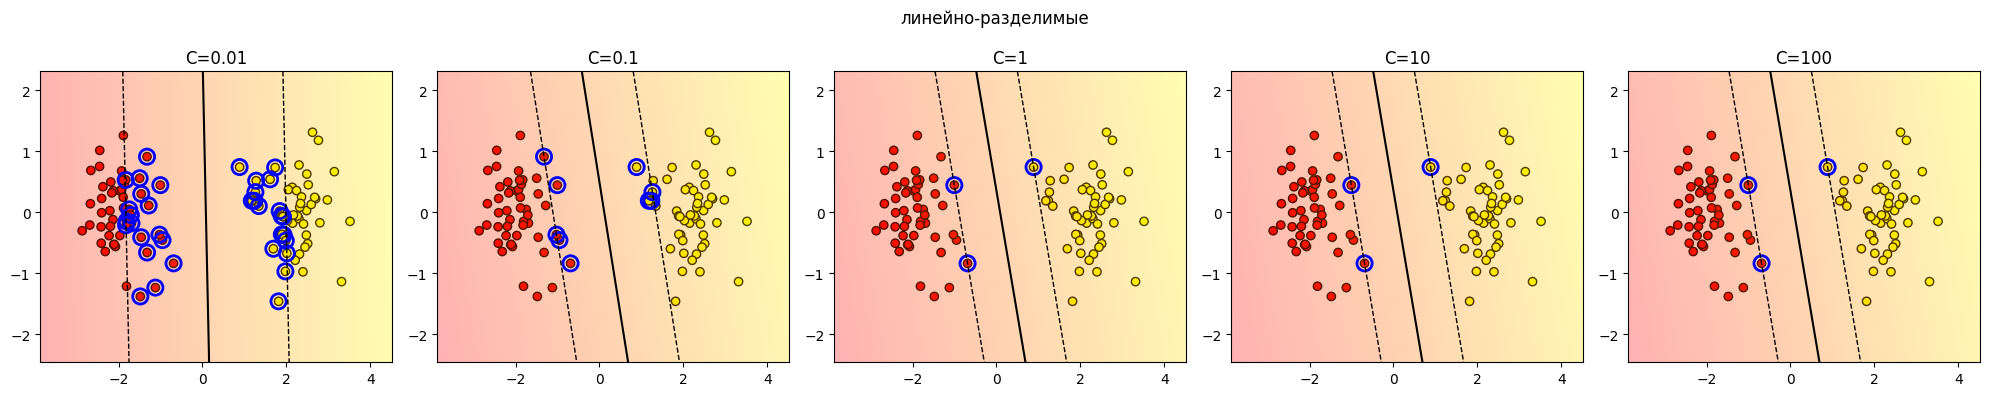


Dataset: не линейно
C=  0.01  опорные векторы: 200
C=   0.1  опорные векторы: 200
C=     1  опорные векторы: 200
C=    10  опорные векторы: 200
C=   100  опорные векторы: 200


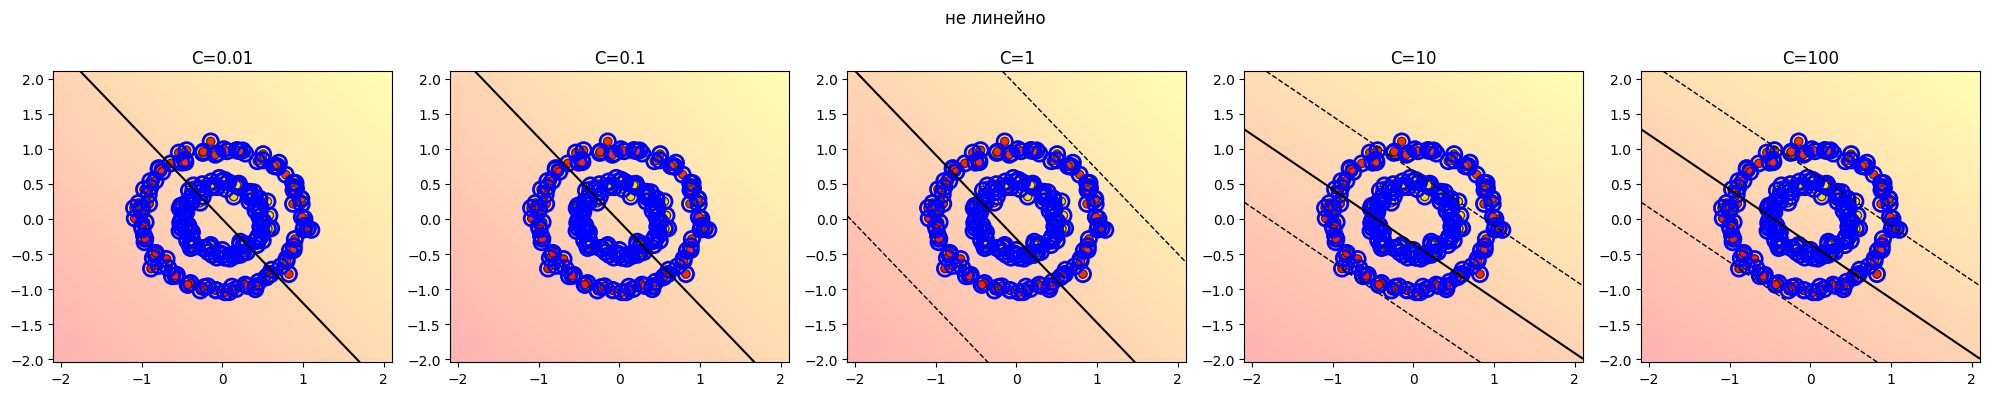


Dataset: плохо разделимые
C=  0.01  опорные векторы:  84
C=   0.1  опорные векторы:  49
C=     1  опорные векторы:  39
C=    10  опорные векторы:  36
C=   100  опорные векторы:  35


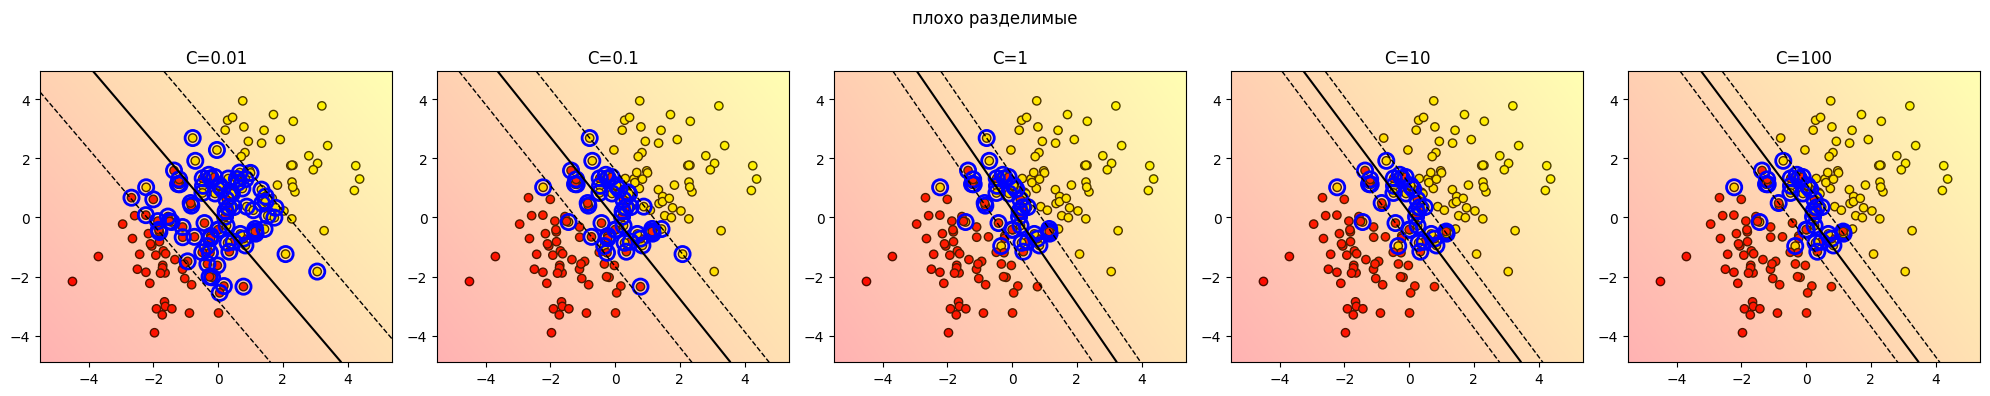

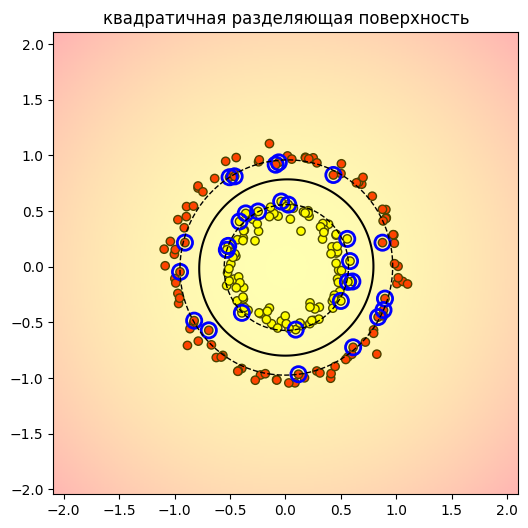

In [ ]:
import numpy as np
from cvxopt import matrix, solvers
from sklearn.base import BaseEstimator
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

solvers.options['show_progress'] = False


def _to_cvxopt_matrix(A, dtype='d'):
    A = np.asarray(A, dtype=float)
    return matrix(A)


class LinearSVM(BaseEstimator):
    def __init__(self, C=1.0, transform=None):
        self.C = float(C)
        self.transform = transform

    def _apply_transform(self, X):
        if self.transform is None:
            return X
        else:
            return self.transform(X)

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).flatten()
        assert set(np.unique(y)).issubset({-1.0, 1.0})

        X = self._apply_transform(X)
        N, d = X.shape


        n_vars = d + 1 + N


        P = np.zeros((n_vars, n_vars))
        P[:d, :d] = np.eye(d)


        q = np.hstack([np.zeros(d + 1), self.C * np.ones(N)])


        G1 = np.zeros((N, n_vars))
        for i in range(N):
            G1[i, :d] = -y[i] * X[i]
            G1[i, d] = -y[i]
            G1[i, d + 1 + i] = -1.0
        h1 = -np.ones(N)


        G2 = np.zeros((N, n_vars))
        G2[:, d + 1:] = -np.eye(N)
        h2 = np.zeros(N)

        G = np.vstack([G1, G2])
        h = np.hstack([h1, h2])


        P_c = _to_cvxopt_matrix(P)
        q_c = _to_cvxopt_matrix(q)
        G_c = _to_cvxopt_matrix(G)
        h_c = _to_cvxopt_matrix(h)


        sol = solvers.qp(P_c, q_c, G_c, h_c)
        x = np.array(sol['x']).flatten()


        w = x[:d].reshape(-1)
        b = float(x[d])
        xi = x[d + 1:]

        self.weights_ = w
        self.bias_ = b
        self.slacks_ = xi
        self.n_features_in_ = d
        self._fit_X = X
        self._fit_y = y
        return self

    def decision_function(self, X):
        X = np.asarray(X, dtype=float)
        X = self._apply_transform(X)
        return (X.dot(self.weights_) + self.bias_).flatten()

    def predict(self, X):
        return np.sign(self.decision_function(X))

    def support_vectors_(self, tol=1e-6):
        fvals = self._fit_X.dot(self.weights_) + self.bias_
        margins = self._fit_y * fvals
        mask = (np.abs(margins - 1.0) <= 1e-4) | (self.slacks_ > tol)
        return self._fit_X[mask], self._fit_y[mask], mask



def quadratic_transform(X):
    X = np.asarray(X)
    x1 = X[:, 0:1]
    x2 = X[:, 1:2]
    return np.hstack([x1, x2, x1 ** 2, x1 * x2, x2 ** 2])




def plot_decision(model, X, y, ax=None, title=None, show_support=True):
    if ax is None:
        ax = plt.gca()


    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolors='k')


    xvals = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 300)
    yvals = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 300)
    xx, yy = np.meshgrid(xvals, yvals)
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model.decision_function(grid).reshape(xx.shape)


    ax.pcolormesh(xx, yy, zz, shading='auto', cmap='autumn', alpha=0.3)


    ax.contour(xx, yy, zz, levels=(0.0,), colors='k', linewidths=1.5)

    ax.contour(xx, yy, zz, levels=tuple(sorted([1.0, -1.0])), colors='k', linestyles='--', linewidths=1.0)

    if show_support:
        sv_X, sv_y, mask = model.support_vectors_()
        if len(sv_X) > 0:
            ax.scatter(sv_X[:, 0], sv_X[:, 1], s=120, facecolors='none', edgecolors='b', linewidths=2)

    ax.set_xlim(xvals[0], xvals[-1])
    ax.set_ylim(yvals[0], yvals[-1])
    if title is not None:
        ax.set_title(title)


def experiment():
    rng = np.random.RandomState(0)


    X1, y1 = make_blobs(n_samples=100, centers=[(-2, 0), (2, 0)], cluster_std=0.6, random_state=1)
    y1 = 2 * (y1 == 1) - 1


    X2, y2 = make_circles(n_samples=200, factor=0.5, noise=0.05, random_state=2)
    y2 = 2 * y2 - 1


    X3, y3 = make_blobs(n_samples=150, centers=[(-1, -1), (1, 1)], cluster_std=1.2, random_state=3)
    y3 = 2 * (y3 == 1) - 1

    datasets = [(X1, y1, 'линейно-разделимые'),
                (X2, y2, 'не линейно'),
                (X3, y3, 'плохо разделимые')]

    Cs = [0.01, 0.1, 1, 10, 100]


    for X, y, name in datasets:
        print('\nDataset:', name)
        fig, axes = plt.subplots(1, len(Cs), figsize=(4 * len(Cs), 4))
        for ax, C in zip(axes, Cs):
            model = LinearSVM(C=C)
            model.fit(X, y)
            sv_X, sv_y, mask = model.support_vectors_()
            print(f'C={C:>6}  опорные векторы: {mask.sum():3d}')
            plot_decision(model, X, y, ax=ax, title=f'C={C}')
        plt.suptitle(name)
        plt.tight_layout()
        plt.show()



    model_q = LinearSVM(C=1.0, transform=quadratic_transform)
    model_q.fit(X2, y2)

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    plot_decision(model_q, X2, y2, ax=ax, title='квадратичная разделяющая поверхность')
    plt.show()


if __name__ == '__main__':
    experiment()


Линейно-разделемые:
При очень малом C (0.01) гиперплоскость сильно «размягчена», поэтому много точек попадает в коридор или нарушает ограничения => 36 SV.

При увеличении C модель становится строже, коридор сужается => число SV резко уменьшается.

Начиная с C >= 1, выборка полностью линейно разделима без ошибок, и SVM находит максимальную разделяющую гиперплоскость с минимальным числом опорных (3 SV).

Дальнейший рост C уже не влияет на решение.

Нелинейная выборка:
При любых значениях C все 200 точек оказываются опорными векторами.

Это означает, что линейная модель не способна выразить разделение данных.

Поэтому для любого C множество ограничений оказывается активным, и гиперплоскость в принципе не может «отодвинуться» так, чтобы часть точек вышла за пределы коридора.

Плохо-разделимая:
При малых C (0.01) - максимальное «смягчение» ограничений => 84 SV, т.е. почти половина выборки лежит в коридоре или нарушает ограничения.

При увеличении C гиперплоскость становится более жёсткой, допускается меньше ошибок => 36-35 SV.

Число опорных постепенно снижается, но не достигает малого значения, как в линейно-разделимом случае.
Это отражает то, что выборка действительно трудно разделима линейно.



poly p=2, C=0.1: 143 опорные вектора
poly p=2, C=1: 29 опорные вектора
poly p=2, C=10: 8 опорные вектора
poly p=2, C=100: 6 опорные вектора
poly p=2, C=1: 29 опорные вектора
poly p=5, C=1: 13 опорные вектора
rbf gamma=0.1, C=1: 35 опорные вектора
rbf gamma=1.0, C=1: 60 опорные вектора


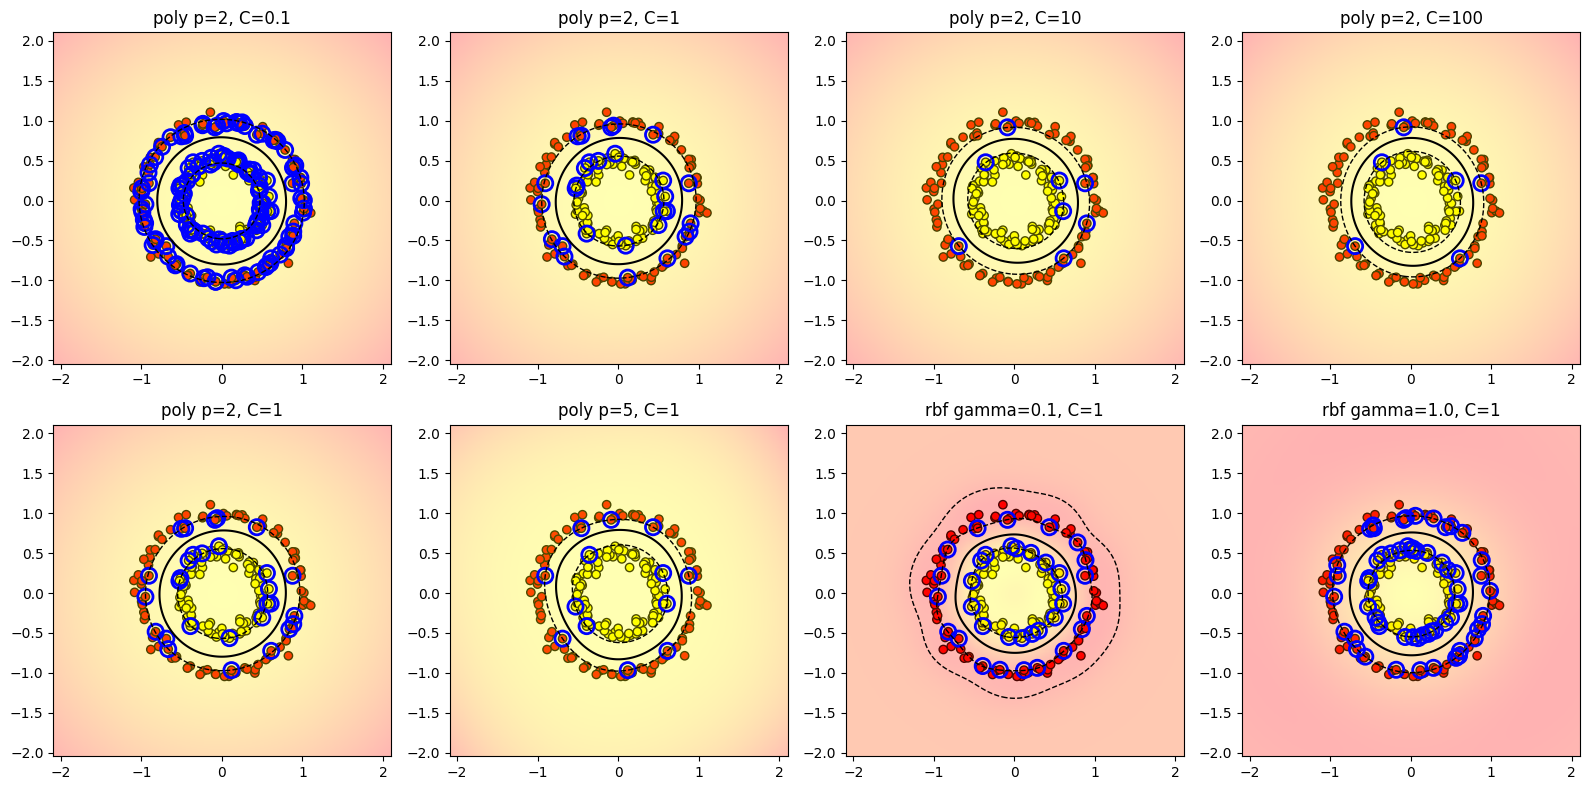

In [ ]:
import numpy as np
from cvxopt import matrix, solvers
from sklearn.base import BaseEstimator
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt

solvers.options['show_progress'] = False


def _to_cvxopt_matrix(A):
    A = np.asarray(A, dtype=float)
    return matrix(A)


class DualSVM(BaseEstimator):
    def __init__(self, C=1.0, kernel='linear', degree=3, gamma=None):
        self.C = float(C)
        self.kernel = kernel
        self.degree = int(degree)
        self.gamma = gamma

    def _kernel_func(self, X, Y=None):
        X = np.asarray(X)
        if Y is None:
            Y = X
        else:
            Y = np.asarray(Y)

        if self.kernel == 'linear':
            return X.dot(Y.T)
        elif self.kernel == 'poly':
            return (X.dot(Y.T) + 1.0) ** self.degree
        elif self.kernel == 'rbf':

            if self.gamma is None:
                self.gamma_ = 1.0 / X.shape[1]
            else:
                self.gamma_ = float(self.gamma)
            X_norm = np.sum(X ** 2, axis=1)[:, None]
            Y_norm = np.sum(Y ** 2, axis=1)[None, :]
            K = X_norm + Y_norm - 2 * X.dot(Y.T)
            return np.exp(-0.5 / self.gamma_ * K)
        else:
            raise ValueError('Unknown kernel: %s' % self.kernel)

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).flatten()
        assert set(np.unique(y)).issubset({-1.0, 1.0})

        self.X_ = X
        self.y_ = y
        N = X.shape[0]


        K = self._kernel_func(X, X)


        Q = np.outer(y, y) * K

        P = _to_cvxopt_matrix(Q)
        q = _to_cvxopt_matrix(-np.ones(N))


        G_top = -np.eye(N)
        G_bottom = np.eye(N)
        G = _to_cvxopt_matrix(np.vstack([G_top, G_bottom]))
        h = _to_cvxopt_matrix(np.hstack([np.zeros(N), self.C * np.ones(N)]))

        A = _to_cvxopt_matrix(y.reshape(1, -1))
        b = _to_cvxopt_matrix(np.array([0.0]))


        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x']).flatten()

        self.alpha_ = alphas

        tol = 1e-6
        sv_mask = alphas > tol
        self.support_mask_ = sv_mask
        self.support_ = X[sv_mask]
        self.support_y_ = y[sv_mask]
        self.support_alpha_ = alphas[sv_mask]


        margin_sv = (alphas > tol) & (alphas < (self.C - 1e-8))
        if np.any(margin_sv):
            idxs = np.where(margin_sv)[0]
        else:
            idxs = np.where(sv_mask)[0]

        if len(idxs) == 0:
            self.intercept_ = 0.0
        else:
            bs = []
            for i in idxs:

                val = np.sum(alphas * y * K[:, i])
                bs.append(y[i] - val)
            self.intercept_ = float(np.mean(bs))

        self.n_features_in_ = X.shape[1]
        return self

    def decision_function(self, X):
        X = np.asarray(X, dtype=float)
        K = self._kernel_func(self.X_, X)
        vals = (self.alpha_ * self.y_)[:, None].T.dot(K)

        return (vals.flatten() + self.intercept_)

    def predict(self, X):
        return np.sign(self.decision_function(X))

    def predict_proba(self, X):

        d = self.decision_function(X)
        p = 1.0 / (1.0 + np.exp(-d))
        probs = np.vstack([1 - p, p]).T
        return probs

    def support_vectors_(self):
        return self.support_, self.support_y_, self.support_alpha_, self.support_mask_




def plot_decision(model, X, y, ax=None, title=None, show_support=True):
    if ax is None:
        ax = plt.gca()


    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolors='k')


    xvals = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 300)
    yvals = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 300)
    xx, yy = np.meshgrid(xvals, yvals)
    grid = np.c_[xx.ravel(), yy.ravel()]


    zz = model.decision_function(grid).reshape(xx.shape)


    ax.pcolormesh(xx, yy, zz, shading='auto', cmap='autumn', alpha=0.3)


    ax.contour(xx, yy, zz,
               levels=(0.0,),
               colors='k',
               linewidths=1.5)


    ax.contour(xx, yy, zz,
               levels=tuple(sorted([1.0, -1.0])),
               colors='k',
               linestyles='--',
               linewidths=1.0)


    if show_support:
        sv_X, sv_y, sv_alpha, sv_mask = model.support_vectors_()
        if len(sv_X) > 0:
            ax.scatter(
                sv_X[:, 0], sv_X[:, 1],
                s=120,
                facecolors='none',
                edgecolors='b',
                linewidths=2
            )

    ax.set_xlim(xvals[0], xvals[-1])
    ax.set_ylim(yvals[0], yvals[-1])

    if title is not None:
        ax.set_title(title)





def experiment():
    rng = np.random.RandomState(0)


    X, y = make_circles(n_samples=200, noise=0.05, factor=0.5, random_state=2)
    y = 2 * y - 1

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    Cs = [0.1, 1, 10, 100]
    kernels = [('poly', 2), ('poly', 5), ('rbf', 0.1), ('rbf', 1.0)]


    for ax, C in zip(axes[0], Cs):
        m = DualSVM(C=C, kernel='poly', degree=2)
        m.fit(X, y)


        sv_X, sv_y, sv_alpha, sv_mask = m.support_vectors_()
        print(f"poly p=2, C={C}: {len(sv_X)} опорные вектора")

        plot_decision(m, X, y, ax=ax, title=f'poly p=2, C={C}')

    for ax, (k, param) in zip(axes[1], kernels):
        if k == 'poly':
            m = DualSVM(C=1.0, kernel='poly', degree=param)
            plot_title = f'poly p={param}, C=1'
        else:
            m = DualSVM(C=1.0, kernel='rbf', gamma=param)
            plot_title = f'rbf gamma={param}, C=1'

        m.fit(X, y)


        sv_X, sv_y, sv_alpha, sv_mask = m.support_vectors_()
        print(f"{plot_title}: {len(sv_X)} опорные вектора")

        plot_decision(m, X, y, ax=ax, title=plot_title)

    plt.tight_layout()
    plt.show()



if __name__ == '__main__':
    experiment()




Как ведёт себя SVM с полиномиальным ядром при разных C и разных степенях p:
Полиномиальное ядро p = 2:
Для p = 2 модель чувствительна к C:
малое C — слишком грубо, большое C — сильно подгоняется под данные.
Оптимальной выглядит область C около 1

p=5:
При той же силе регуляризации (C = 1) увеличенная степень ядра (p = 5) даёт меньше опорных векторов: 13 вместо 29 при p = 2.

Это означает, что модель стала существенно более гибкой: ядро p = 5 создаёт очень извилистое пространство признаков, позволяя намного точнее подгоняться под данные.

Как ведёт себя SVM с RBF-ядром при разных gamma:

γ = 0.1 (малое gamma)
Число SV = 35.
 Ядро широкое, влияние точек распространяется далеко, модель более гладкая и устойчивая.

γ = 1.0 (большее gamma)
Число SV = 60 (значительно больше).
Ядро более локальное, модель становится более гибкой, граница начинает подстраиваться под локальные детали.
Признак возможного переобучения (большее число SV).